# Project 6 - KDE and Marathon Results
## Matthew Naeher



## Introduction

Kernel density estimation (KDE) offers a method by which the probability density function (PDF) of a random variable can be estimated. While histograms can give a rough idea of the density of the distribution of data, the density function is influenced by the selection of bin widths and endpoints. KDE attempts to remedy these shortcomings by estimating a smooth, continuous curve that represents the PDF. 

In this project, I will be using SciPy's implementation of the Gaussian KDE to predict the sex of a marathon runner based on their finish time and age. To do this, the data from the given marathon containing the sex, finish time, age, and nationality of each runner will be loaded into a Pandas DataFrame. Once the data is processed, a model will be created by using the Gaussian KDE that utilizes Bayes Theory to predict if a runner is male or female. Once I have calculated the KDE's accuracy in predicting the sex of a runner given their age and marathon time, I will create a second model using sklearn's k-nearest neighbors algorithm and then compare the accuracy of the two models. Since a runner can only be male or female, we can assume that sex would be randomly predicted with about 50% accuracy. Thus, a successful model would be one that can predict sex with greater than 50% accuracy.

Finally, KDE will also be used on datasets that contain American runners and foreign runners. The accuracy of these two models will then be compared to see if a more accurate model can be generated for Americans (who there is more than four times as many data points for) than foreigners.




## Preliminaries

In the code below, the csv file from the course website is downloaded and put into a Pandas DataFrame. A column is added to the DataFrame that holds each runner's total time in minutes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Read csv file and load in dataframe
df = pd.read_csv("https://www.mth548.org/_static/kde_marathon_results/marathon_results.csv")
# Add column that records the total time in minutes
df["tot_minutes"] = pd.to_timedelta(df["Finish"]).dt.total_seconds()/60


Since we are interested in predicting the sex of a runner based on their time and age, the DataFrame is divided into two separate DataFrames for males and females.

In [2]:
runners_sex = df.groupby('M/F')

# Create new DataFrame for females
females = runners_sex.get_group('F')
females = females.reset_index()

#Create new DataFrame for males
males = runners_sex.get_group('M')
males = males.reset_index()


## Estimating Probability Density Functions using KDEs

In [3]:
from scipy.stats import gaussian_kde

Now, we will use SciPy's Gaussian KDE to estimate the probability density function (PDF) for the two sets of data using two inputs: age and total time. The PDF with two variables can be defined as:

$$P((X,Y)\in A) =\iint_{A}^{}f_{XY}(x,y)dxdy$$

In [4]:
mkde = gaussian_kde(males[["tot_minutes","Age"]].T)
fkde = gaussian_kde(females[["tot_minutes","Age"]].T)


Now that we have our KDE for males and females, we will visualize the individual estimated PDFs. Since we are dealing with multivariate data, we will either need to use a 3D graph or contour plots to visualize the data. For the ease of viewing one on top of the other with a shared x-axis, I used contour plots. The raw data (each dot representing an individual runner) is also displayed on the plots. 

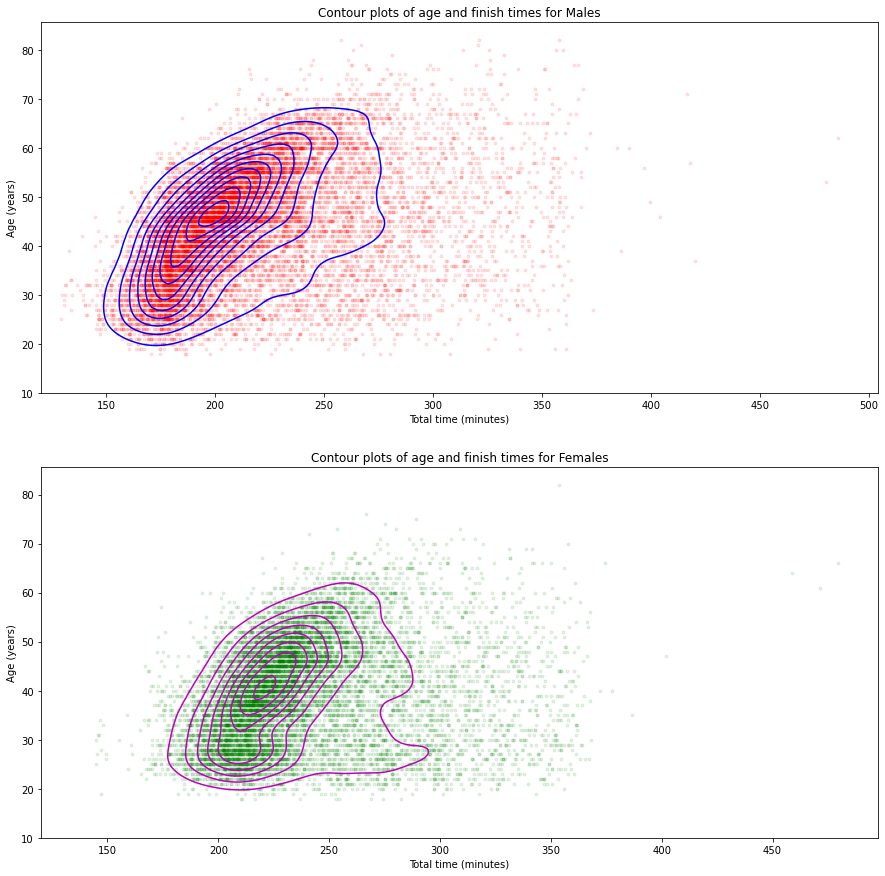

In [5]:
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)


xM= np.linspace(120, 360, 100)
yM = np.linspace(10, 70, 100)
XM, YM = np.meshgrid(xM, yM)
ZM = mkde(np.array([XM.flatten(), YM.flatten()])).reshape(XM.shape)
ax1.plot(males["tot_minutes"], males["Age"], 'r.', alpha=0.1)
male_contour = ax1.contour(XM, YM, ZM, levels=10, colors='b', zorder=10)

xF= np.linspace(120, 360, 100)
yF = np.linspace(10, 70, 100)
XF, YF = np.meshgrid(xF, yF)
ZF = fkde(np.array([XF.flatten(), YF.flatten()])).reshape(XF.shape)
ax2.plot(females["tot_minutes"], females["Age"], 'g.', alpha=0.1)

female_contour = ax2.contour(XF, YF, ZF, levels=10, colors='m', zorder=10)

#plt.setp(ax[0],xlabel='Time (minutes)')
#, ylabel='Age (years)')

ax1.set_xlabel("Total time (minutes)")
ax1.set_ylabel("Age (years)")
ax2.set_title("Contour plots of age and finish times for Females")
ax2.set_xlabel("Total time (minutes)")
ax2.set_ylabel("Age (years)")
ax1.set_title("Contour plots of age and finish times for Males")
plt.show()

Notice how the peaks of the contour plots align with the areas that have the highest density of runners. This indicates that our KDE has successfully created a smooth surface using the observations it was provided.

## Predicting Sex using KDE and Bayes Theorem

Now that we have the kernel density estimates for male and female runners based on age and finish time, we can use Bayes Theorem to predict the sex of a runner. 

First, we will take a random sample of half of the DataFrame and use it as training data. The remaining half of the data will be used as testing data.

In [6]:
# Set aside half of DataFrame for training data
train_frac = 0.5
train_df = df.sample(frac=train_frac, random_state=0).copy()


In [7]:
# Drop the training data from the original dataframe to get our testing data
test_df  = df.drop(train_df.index).copy()


In [8]:
# Split the training data into two groups for males and females
train_dfm = train_df[train_df["M/F"] == "M"]
train_dff = train_df[train_df["M/F"] == "F"]

# Take the KDE for both datasets
kdem = gaussian_kde(train_dfm[["tot_minutes", "Age"]].T)
kdef = gaussian_kde(train_dff[["tot_minutes", "Age"]].T)

# Record the number of males and females
mc = len(train_dfm)
fc = len(train_dff)

# Based on our data, find the independent probabilities of being male or female
prob_f = fc/(fc+mc)
prob_m = mc/(fc+mc)




Bayes Theorem is implemented in the cell below. The function predictor_f takes a datapoint, t,  that holds a runner's age and finish time and returns the probability of being female. This is based off the following formula where F is the event that a runner is female and t is the event that a runner has a certain time and age:

$$P(F|t)=\frac{P(t|F)P(F)}{P(t)}$$

Since the runner's sex can be treated as a Bernoulli trial where a runner is either male or female and we've already defined a function to determine the probability of a runner being female, we can use the following formula to predict if a runner is male:

$$P(M)=1-P(F)$$



In [9]:
# Use Bayes theorem to predict if female
def predictor_f(t):
    return (kdef(t)*prob_f)/(kdef(t)*prob_f + kdem(t)*prob_m)

# Use complement to predict if male
def predictor_m(t):
    return 1 - predictor_f(t)

Looking back at the plot of raw data from male and female runners, it can be seen that very few females finished the race in under 150 minutes where there were several males who accomplished the feat. Thus, it can be expected that a time under 150 would return a higher probability of being male. Below, I will use the model to predict the sex of a 30 year old with a finish time of 145 minutes.

In [10]:
odds_m = predictor_m([145,30])
odds_f = predictor_f([145,30])
print("Predicted probability that runner is a male: ", odds_m)
print("Predicted probability that runner is a female: ", odds_f)

Predicted probability that runner is a male:  [0.95302421]
Predicted probability that runner is a female:  [0.04697579]


As expected, the runner was predicted to be male with a 95% probability.

Now that our model is set up, we will use the testing data to test the accuracy of the model.

In [11]:
# Create a new column of the DataFrame that holds the probability of being male or female
test_df["prob_F"] = predictor_f(test_df[["tot_minutes", "Age"]].T) 
test_df["prob_M"] = predictor_m(test_df[["tot_minutes", "Age"]].T) 



To find the overall accuracy, we will say that a runner is predicted as female if the probability is greater than 0.5. If the odds are greater than 50% and the actual sex of the individual is female, this will be recorded as a successful prediction. This will be divided by the number of datapoints in the testing data to get the overall accuracy of the model. Since there are only two outcomes, male or female, the male accuracy will equal the female accuracy.

In [12]:
accuracy_f = sum((test_df["prob_F"] >= 0.5) == (test_df["M/F"] == "F"))/len(test_df)
print("Accuracy in predicting sex: ", accuracy_f)

Accuracy in predicting sex:  0.7615027758764925


In [13]:
accuracy_m = sum((test_df["prob_M"] >= 0.5) == (test_df["M/F"] == "M"))/len(test_df)
print("Accuracy in predicting sex: ", accuracy_m)

Accuracy in predicting sex:  0.7615027758764925


The resulting accuracy shows that there is some value to this model, as if we randomly guessed the sex of a runner we would have a 50/50 chance of guessing correctly.

## Predicting Sex using K-Nearest Neighbors

K-nearest neighbors (k-NN) is another machine learning algorithm that can be used to create a model that will predict the sex of a runner based on their finish time and age. k-NN is built on the premise that things that are near each other should be classified together. It is a supervised algorithm, meaning that it takes input data with corresponding labels to learn a function that will predict the correct classification when a data point is provided without a label. In this use of k-NN, the inputed data will be the age and finish time of a runner and the labels will be the runner's sex.

In [14]:
from sklearn.neighbors import KNeighborsClassifier

In [15]:
knn = KNeighborsClassifier(n_neighbors=5)
# Fit knn to our training data
knn.fit(train_df[["tot_minutes", "Age"]], train_df["M/F"])

KNeighborsClassifier()

In [16]:
# Make predictions on testing data using our trained classifier
knn_predictions = knn.predict(test_df[["tot_minutes", "Age"]])

To test the accuracy of the k-NN, a function will be defined that checks if the predicted label matches the actual label. The number of matches will then be divided by the number of datapoints in the testing data to calculate the accuracy.

In [17]:
#Function that tests the accuracy of a given classfier.
def test_accuracy(predicted_labels, df_labels):
    correct = 0
    
    # Check each test image for equivalence and keep track of when correct and incorrect
    for i in range(len(df_labels)):
        if predicted_labels[i] == df_labels[i]:
            correct+=1

    
    accuracy = correct/len(df_labels)

    return accuracy

In [18]:
actual_labels = test_df["M/F"].to_numpy()
knn_accuracy = test_accuracy(knn_predictions, actual_labels)
print("Accuracy of predicting sex using k-NN:", knn_accuracy)

Accuracy of predicting sex using k-NN: 0.7281162065556316


### Comparing Accuracy of KDE with k-NN

In [19]:
print("Accuracy in predicting sex using KDE: ", accuracy_m)
print("Accuracy of predicting sex using k-NN:", knn_accuracy)

Accuracy in predicting sex using KDE:  0.7615027758764925
Accuracy of predicting sex using k-NN: 0.7281162065556316


While using k-NN to predict the sex of runners gave us a model that is significantly better than randomly guessing, it is slightly less accurate than the model that uses KDE. 

## Accuracy of Predicting Sex of American Runners vs. Foreign Runners using KDE

The final section of this project will explore if the sex of Americans can be predicted with greater accuracy than foreign runners. Since the dataset contains less that 5000 foreign runners (compared to over 21,000 Americans), I have lumped all foreign runners into a single dataframe. While splitting between individual countries would likely give more interesting results, we would not have nearly enough data to train the model with.

In [20]:
# Group by country and make DataFrame of only Americans
country_group = df.groupby('Country')
americans = country_group.get_group('USA')

# Add all non-Americans to a second DataFrame
foreigners = df.drop(americans.index).copy()


In [21]:
#Create dataframe of just American females
f_country_group = females.groupby('Country')


american_females = f_country_group.get_group('USA')
 
american_females = american_females.reset_index()
# Use remaining females as foreigners DataFrame
foreign_females = females.drop(american_females.index).copy()

# Create dataframe of American males
m_country_group = males.groupby('Country')

american_males = m_country_group.get_group('USA')
 
american_males = american_males.reset_index()
# Create dataframe of foreign males
foreign_males = males.drop(american_males.index).copy()

Just as in the first part, I will use SciPy's Gaussian KDE to estimate the PDFs for American males and females as well as foreign males and females.

In [22]:
american_mkde = gaussian_kde(american_males[["tot_minutes","Age"]].T)
american_fkde = gaussian_kde(american_females[["tot_minutes","Age"]].T)

foreign_mkde = gaussian_kde(foreign_males[["tot_minutes","Age"]].T)
foreign_fkde = gaussian_kde(foreign_females[["tot_minutes","Age"]].T)

For both Americans and foreigners, the DataFrames will be randomly split in half where half is used for training and the other is set aside for testing.

In [23]:
train_frac = 0.5
american_train_df = americans.sample(frac=train_frac, random_state=0).copy()

american_test_df  = americans.drop(american_train_df.index).copy()


In [24]:
foreigner_train_df = foreigners.sample(frac=train_frac, random_state=0).copy()
foreigner_test_df  = foreigners.drop(foreigner_train_df.index).copy()


In [25]:
# Split the training data into two groups for males and females
american_train_dfm = american_train_df[american_train_df["M/F"] == "M"]
american_train_dff = american_train_df[american_train_df["M/F"] == "F"]

# Take the KDE for both datasets
kdem = gaussian_kde(american_train_dfm[["tot_minutes", "Age"]].T)
kdef = gaussian_kde(american_train_dff[["tot_minutes", "Age"]].T)

# Record number of males and females
mc = len(american_train_dfm)
fc = len(american_train_dff)

# Take independent probabilities 
prob_f = fc/(fc+mc)
prob_m = mc/(fc+mc)

Now, I will use the predictor functions I defined earlier to predict the sex of each American runner. From these probabilities, I will test the accuracy of the model.

In [26]:
american_test_df["prob_F"] = predictor_f(american_test_df[["tot_minutes", "Age"]].T) 
american_test_df["prob_M"] = predictor_m(american_test_df[["tot_minutes", "Age"]].T) 



In [27]:
# Find accuracy by treating a probablility of greater than 50% as being female.
# Divide the number of matches by the number of datapoints
american_accuracy = sum((american_test_df["prob_F"] >= 0.5) == (american_test_df["M/F"] == "F"))/len(american_test_df)


The same process that was used for the group of American runners will now be used on the foreign runners.

In [28]:
# Split the training data into two groups for males and females
foreigner_train_dfm = foreigner_train_df[foreigner_train_df["M/F"] == "M"]
foreigner_train_dff = foreigner_train_df[foreigner_train_df["M/F"] == "F"]

# Take the KDE for both datasets
kdem = gaussian_kde(foreigner_train_dfm[["tot_minutes", "Age"]].T)
kdef = gaussian_kde(foreigner_train_dff[["tot_minutes", "Age"]].T)

# Record number of males and females
mc = len(foreigner_train_dfm)
fc = len(foreigner_train_dff)

# Take independent probabilities 
prob_f = fc/(fc+mc)
prob_m = mc/(fc+mc)

In [29]:
foreigner_test_df["prob_F"] = predictor_f(foreigner_test_df[["tot_minutes", "Age"]].T) 
foreigner_test_df["prob_M"] = predictor_m(foreigner_test_df[["tot_minutes", "Age"]].T) 



In [30]:
foreign_accuracy = sum((foreigner_test_df["prob_F"] >= 0.5) == (foreigner_test_df["M/F"] == "F"))/len(foreigner_test_df)
print("Accuracy of predicting American runner's sex: ", american_accuracy)
print("Accuracy of predicting foreign runner's sex:  ", foreign_accuracy)

Accuracy of predicting American runner's sex:  0.7657449366503283
Accuracy of predicting foreign runner's sex:   0.7465753424657534


Upon reviewing the results of the accuracy of the model for Americans and foreigners, it appears that the sex of American runners can be predicted with slightly higher accuracy. However, this difference is small as it is only about 2%. Presumably since this race was in the US, the vast majority of runners were American. Thus, I had to include all foreign nationals together so that it would be a large enough dataset to work with. If there was enough runners from every country and we could divide the foreigners into groups by their respective countries, we would likely see a greater level of variation in accuracy between countries.

##  Conclusion

Using a Gaussian KDE to predict the sex of marathon runners, we achieved roughly 76% accuracy. This is a significant improvement over the 50% accuracy that would be expected if guessing a marathon runner's sex at random. Additionally, the results showed that the two-dimensional KDE using age and finish time as inputs was more accurate than a model using k-NN on the same inputs. Finally, we saw that the model using KDE for American runners did not differ greatly in accuracy from the model only including foreign runners. 